In [ ]:
import json
import pandas as pd
import pickle
from tqdm import tqdm
from bson import json_util
from pymongo import MongoClient
from sklearn.feature_extraction.text import TfidfVectorizer 
import operator
from sklearn.metrics.pairwise import cosine_similarity
import re
from konlpy.tag import Okt
okt=Okt()
import warnings
warnings.simplefilter("ignore")
documents=pd.read_excel('majors_textSet_복구.xlsx')

In [2]:
count=len(documents)               ##비교하고 싶은 학과 개수 설정,  현재는 documents 전부로 설정
result=3                           ##한 학과 당 도출해내고 싶은 유사한 학과 개수




text_name=[]                     
for i in range(count):            
    text_name.append(documents['univname'][i]+' '+documents['name'][i])
    
text_both=[]
for i in range(count):
    text_both.append(str(documents['text_intr'][i])+' '+str(documents['text_lect'][i]))

In [ ]:
def preprocess(documents):      
# 저장된 데이터에서 필요한건 '학교명', '학과명', '학과소개글', '배우는과목소개글'
# 따라서 얘네 4명만 살리고 학교명과 학과명은 하나로 합친 데이터정제 코드 
    documents = documents[['name','univname','text_intr','text_lect']]
    documents['name']=documents['univname']+' '+documents['name']
    documents = documents.drop(['univname'],axis=1)
    documents['text_intr']=documents['text_intr']+' '+documents['text_lect']
    documents = documents.drop(['text_lect'],axis=1)
    documents = documents.dropna(axis=0)
    documents=documents.reset_index()
    return documents




def trans_hangul(documents):
    text_list = list(documents['text_intr'])
    hangul = re.compile('[^ ㄱ-ㅣ가-힣]+')
    for i in range(len(text_list)):   
        text_list[i] = hangul.sub('', text_list[i])
        text_list[i]=(' '.join(okt.nouns(text_list[i])))
        
    return text_list





documents= preprocess(documents)
documents = trans_hangul(documents)

documents

## TF-IDF
### 첫번째는 같은 대학 포함, 두번째는 같은 대학 불포함

In [26]:
vectorizer = TfidfVectorizer()
X_both = vectorizer.fit_transform(text_both)
X_both = X_both.todense()


In [ ]:
#학과 서로 유사도 계산하기 (같은 대학 포함)
result={}
for j in range(count):
    temparr=[]                   
    major2simil={}                
    for i in range(count):       #j와 j를 포함한 모든 학과들과의 유사도 계산 후 temparr에 저장
        temp=cosine_similarity(X_both[j],X_both[i])    #temp : j와 i 학과의 유사도 임시저장
        temparr.append(temp)
        
        major2simil[text_name[i]]=(str(temp))[2:-2]     #학교명:유사도를 딕셔너리에 삽입
            
        tt=sorted(major2simil.items(),key=operator.itemgetter(1),reverse=True)     #유사도가 가장 높은 순으로 정열        

    # j와 유사도가 가장높은 5개를 추출
    top5=[]
    for q in range(1,result+1):         #1부터 시작하는 이유는 0번째, 즉 유사도가 제일 높은 것이 자기 자신이기 떄문에
        top5.append(tt[q][0])
    print(text_name[j],'와 유사한 학과는\n', top5,'입니다. \n')
    result[text_name[j]]=top5

In [ ]:
#(같은 대학 불포함)
# 아이디어 : 학교명이 같으면 major2simil이란 딕셔너리에 추가하지 않는다.
result={}
for j in range(count):
    temparr=[]                   
    major2simil={}                
    for i in range(count):       #j와 j를 포함한 모든 학과들과의 유사도 계산 후 temparr에 저장
        temp=cosine_similarity(X_both[j],X_both[i]) 
        temparr.append(temp)
        
        if text_name[i].split()[0] == text_name[j].split()[0]: #같은 학교명이라면 pass
            pass
        
        else:                                   #학교명이 다르면 학교명:유사도를 딕셔너리에 추가
            major2simil[text_name[i]]=(str(temp))[2:-2]
            
        sorted_major2simil=sorted(major2simil.items(),key=operator.itemgetter(1),reverse=True)     #유사도가 가장 높은 순으로 정열        

    # j와 유사도가 가장높은 5개를 추출
    top5=[]
        
    for q in range(1,result+1):         #1부터 시작하는 이유는 0번째, 즉 유사도가 제일 높은 것이 자기 자신이기 떄문에
        top5.append(sorted_major2simil[q][0])
    print(text_name[j],'와 유사한 학과는\n', top5,'입니다.')
    result[text_name[j]]=top5

## Doc2vec

In [10]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize

# 문서들 tag화하기
tagged_text_both = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(text_both)]

In [11]:
## 모델 학습하기
max_epochs = 50
vec_size = 20
alpha = 0.025

model = Doc2Vec(vector_size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                dm =1)
  
model.build_vocab(tagged_text_both)

for epoch in range(max_epochs):
    print('iteration {0}'.format(epoch))
    model.train(tagged_text_both,
                total_examples=model.corpus_count,
                epochs=model.epochs)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

model.save("d2v.model")
print("Model Saved")

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
iteration 26
iteration 27
iteration 28
iteration 29
iteration 30
iteration 31
iteration 32
iteration 33
iteration 34
iteration 35
iteration 36
iteration 37
iteration 38
iteration 39
iteration 40
iteration 41
iteration 42
iteration 43
iteration 44
iteration 45
iteration 46
iteration 47
iteration 48
iteration 49
Model Saved


In [18]:
## 학습된 모델을 바탕으로 doc2vec기반 유사학과 도출하기
model= Doc2Vec.load("d2v.model")

vector_arr=[]
for i in range(count):
    data = word_tokenize(text_both[i].lower())
    v=model.infer_vector(data)
    vector_arr.append(v)
    
for i in range(count):
    temp=[]
    for x in range(result):
        temp.append(text_name[int(model.docvecs.most_similar(i)[x][0])])
    print(text_name[i],'와(과) 유사한 학과는 ',temp)

동국대학교 법학과 와(과) 유사한 학과는  ['국민대학교 법학부', '숙명여자대학교 법학부', '광운대학교 법학부']
동국대학교 국어국문문예창작학부 와(과) 유사한 학과는  ['대전대학교 국어국문창작학전공', '목포대학교 영어영문학과', '한남대학교 국어국문ㆍ창작학과']
동국대학교 영어영문학부 와(과) 유사한 학과는  ['인천대학교 영어영문학과', '목포대학교 영어영문학과', '한경대학교 영어학과']
동국대학교 일본학과 와(과) 유사한 학과는  ['동국대학교 중어중문학과', '전남대학교 일본학전공', '동덕여자대학교 중어중국학과']
동국대학교 중어중문학과 와(과) 유사한 학과는  ['동국대학교 일본학과', '전남대학교 일본학전공', '삼육대학교 중국어학과']
동국대학교 철학과 와(과) 유사한 학과는  ['인하대학교 철학과', '한국외국어대학교 철학과', '서울대학교 철학과']
동국대학교 사학과 와(과) 유사한 학과는  ['서강대학교 사학전공', '연세대학교 사학과', '한남대학교 사학전공']
동국대학교 교육학과 와(과) 유사한 학과는  ['서울대학교 교육학과', '국민대학교 교육학과', '목포대학교 교육학과']
동국대학교 국어교육과 와(과) 유사한 학과는  ['경희대학교 국어국문학과', '대구교육대학교 초등국어교육과', '이화여자대학교 국어교육과']
동국대학교 역사교육과 와(과) 유사한 학과는  ['충북대학교 역사교육과', '인천대학교 역사교육과', '국민대학교 한국역사학과']
동국대학교 지리교육과 와(과) 유사한 학과는  ['서울대학교 지리교육과', '한국교원대학교 지리교육과', '이화여자대학교 지리교육전공']
동국대학교 수학교육과 와(과) 유사한 학과는  ['인천대학교 수학교육과', '제주대학교 수학교육과', '서울대학교 수학교육과']
동국대학교 가정교육과 와(과) 유사한 학과는  ['한국교원대학교 가정교육과', '경북대학교 가정교육과', '안동대학교 생활복지학과']
동국대학교 체육교육과 와(과) 유사한 학과는  ['국민대학교 스포츠교육학과', '인천대학교

서강대학교 화학전공 와(과) 유사한 학과는  ['한국외국어대학교 화학과', 'KAIST 화학과', '세종대학교 화학과']
서강대학교 생명과학전공 와(과) 유사한 학과는  ['충북대학교 생명과학부', '서울시립대학교 생명과학과', '한국외국어대학교 생명공학과']
서강대학교 경영학전공 와(과) 유사한 학과는  ['성균관대학교 경영학과', '서울시립대학교 경영학부', '경희대학교 경영학과']
삼육대학교 간호학과 와(과) 유사한 학과는  ['안동대학교 간호학과(4년제)', '충북대학교 간호학과', '동명대학교 간호학과']
삼육대학교 물리치료학과 와(과) 유사한 학과는  ['선문대학교 물리치료학과', '대전대학교 물리치료학과', '을지대학교 물리치료학과']
삼육대학교 사회복지학과 와(과) 유사한 학과는  ['건양대학교 사회복지학과', '전북대학교 사회복지학과', '대진대학교 사회복지학과']
삼육대학교 보건관리학과 와(과) 유사한 학과는  ['초당대학교 간호학과', '경일대학교 간호학과', '한남대학교 간호학과']
삼육대학교 상담심리학과 와(과) 유사한 학과는  ['건양대학교 심리상담치료학과', '동명대학교 상담심리학과', '김천대학교 상담심리치료학과']
삼육대학교 식품영양학과 와(과) 유사한 학과는  ['동덕여자대학교 식품영양학과', '경남과학기술대학교 영양학전공', '순천향대학교 식품영양학과']
삼육대학교 생활체육학과 와(과) 유사한 학과는  ['동의대학교 체육학과', '순천향대학교 사회체육학과', '선문대학교 스포츠과학전공']
삼육대학교 약학과 와(과) 유사한 학과는  ['충북대학교 약학과', '순천대학교 약학과', '충북대학교 제약학과']
삼육대학교 건축학과(5년제) 와(과) 유사한 학과는  ['대전대학교 건축학과(5년제)', '대진대학교 휴먼건축공학부', '한경대학교 건축학전공']
삼육대학교 아트앤디자인학과 와(과) 유사한 학과는  ['국민대학교 시각디자인학과', '국민대학교 영상디자인학과', '동덕여자대학교 미디어디자인학과']
삼육대학교 중국어학과 와(과) 유

서울시립대학교 음악학과 와(과) 유사한 학과는  ['추계예술대학교 국악과', '이화여자대학교 관현악과', '숙명여자대학교 성악과']
서울시립대학교 스포츠과학과 와(과) 유사한 학과는  ['숙명여자대학교 체육교육과', '숭실대학교 스포츠학부', '중원대학교 스포츠지도전공']
서울시립대학교 행정학과 와(과) 유사한 학과는  ['한국외국어대학교 행정학과', '가톨릭대학교 행정학전공', '숙명여자대학교 행정학과']
서울시립대학교 국제관계학과 와(과) 유사한 학과는  ['숭실대학교 정치외교학과', '가톨릭대학교 국제학부', '중앙대학교 정치국제학과']
서울시립대학교 경제학부 와(과) 유사한 학과는  ['연세대학교 경제학부', '동덕여자대학교 경제학과', '가톨릭대학교 경제학전공']
서울시립대학교 사회복지학과 와(과) 유사한 학과는  ['한국성서대학교 사회복지학과', '성결대학교 사회복지학과', '대진대학교 사회복지학과']
서울시립대학교 세무학과 와(과) 유사한 학과는  ['강남대학교 경제세무학과', '경남과학기술대학교 회계학과', '건양대학교 세무학과']
숙명여자대학교 의류학과 와(과) 유사한 학과는  ['성신여자대학교 의류산업학과', '서울여자대학교 패션산업학과', '건국대학교 의상디자인학과']
숙명여자대학교 식품영양학과 와(과) 유사한 학과는  ['가톨릭대학교 식품영양학전공', '안양대학교 식품영양학과', '대진대학교 식품영양학과']
숙명여자대학교 시각ㆍ영상디자인과 와(과) 유사한 학과는  ['연세대학교 생활디자인학과', '이화여자대학교 디자인학부', '동의대학교 디자인조형학과']
숙명여자대학교 산업디자인과 와(과) 유사한 학과는  ['연세대학교 생활디자인학과', '서울시립대학교 공업디자인전공', '건국대학교 산업디자인학과']
숙명여자대학교 환경디자인과 와(과) 유사한 학과는  ['동명대학교 실내건축학과', '대전대학교 건축학과(5년제)', '경희대학교 건축학과']
숙명여자대학교 공예과 와(과) 유사한 학과는  ['동덕여자대학교 디지털공예과', '홍익대학교 섬유미술

숭실대학교 행정학부 와(과) 유사한 학과는  ['경희대학교 행정학과', '국민대학교 행정학과', '상명대학교 공공인재학부']
숭실대학교 정치외교학과 와(과) 유사한 학과는  ['한국외국어대학교 정치외교학과', '한양대학교 정치외교학과', '서울시립대학교 국제관계학과']
숭실대학교 정보사회학과 와(과) 유사한 학과는  ['단국대학교 정치외교학과', '전북대학교 사회학과', '명지대학교 정치외교학과']
숭실대학교 언론홍보학과 와(과) 유사한 학과는  ['순천향대학교 미디어커뮤니케이션학과', '숙명여자대학교 미디어학부', '세종대학교 미디어커뮤니케이션학과']
숭실대학교 평생교육학과 와(과) 유사한 학과는  ['동의대학교 평생교육ㆍ청소년상담학과', '인천대학교 창의인재개발학과', '부경대학교 평생교육ㆍ상담학과']
숭실대학교 수학과 와(과) 유사한 학과는  ['전남대학교 수학과', '대진대학교 수학과', '인천대학교 수학과']
숭실대학교 물리학과 와(과) 유사한 학과는  ['한양대학교 물리학과', 'GIST 물리전공', '가톨릭대학교 물리학전공']
숭실대학교 화학과 와(과) 유사한 학과는  ['가톨릭대학교 화학전공', '고려대학교 화학과', '아주대학교 화학과']
숭실대학교 정보통계ㆍ보험수리학과 와(과) 유사한 학과는  ['경성대학교 수학응용통계학부', '숙명여자대학교 통계학과', '한국외국어대학교 통계학과']
숭실대학교 의생명시스템학부 와(과) 유사한 학과는  ['수원대학교 바이오화학산업학부', '충남대학교 생화학과', '아주대학교 화학과']
아주대학교 수학과 와(과) 유사한 학과는  ['한국외국어대학교 수학과', '서울시립대학교 수학과', 'KAIST 수리과학과']
아주대학교 물리학과 와(과) 유사한 학과는  ['성균관대학교 물리학과', '인하대학교 물리학과', '동아대학교 신소재물리학과']
아주대학교 화학과 와(과) 유사한 학과는  ['한양대학교 화학과', '한국외국어대학교 화학과', '숭실대학교 화학과']
아주대학교 생명과학과 와(과) 유사한 학과는  ['GIS

강릉원주대학교 수학과 와(과) 유사한 학과는  ['KAIST 수리과학과', '서울시립대학교 수학과', '성균관대학교 수학과']
강릉원주대학교 정보통계학과 와(과) 유사한 학과는  ['안동대학교 정보통계학과', '한국외국어대학교 통계학과', '이화여자대학교 통계학과']
강릉원주대학교 물리학과 와(과) 유사한 학과는  ['광운대학교 전자바이오물리학과', '명지대학교 물리학과', '숙명여자대학교 응용물리전공']
강릉원주대학교 생물학과 와(과) 유사한 학과는  ['순천대학교 생물학과', '한남대학교 생명시스템과학과', '강릉원주대학교 해양분자생명과학과']
강릉원주대학교 대기환경과학과 와(과) 유사한 학과는  ['연세대학교 대기과학과', '경상대학교 지질과학과', '연세대학교 지구시스템과학과']
강릉원주대학교 화학신소재학과 와(과) 유사한 학과는  ['순천향대학교 화학과', '세종대학교 화학과', '동아대학교 화학과']
선문대학교 제약생명공학과 와(과) 유사한 학과는  ['GIST 생명과학전공', '순천향대학교 의약공학과', 'KAIST 생명과학과']
선문대학교 식품과학ㆍ수산생명의학부 와(과) 유사한 학과는  ['안동대학교 식품영양학과', '순천대학교 식품과학부', '중원대학교 식품공학과']
선문대학교 스포츠과학전공 와(과) 유사한 학과는  ['인천대학교 운동건강학부', '순천향대학교 스포츠의학과', '삼육대학교 생활체육학과']
선문대학교 무도경호학전공 와(과) 유사한 학과는  ['초당대학교 검도학과', '김천대학교 작업치료학과', '우송대학교 언어치료ㆍ청각재활학과']
선문대학교 간호학과 와(과) 유사한 학과는  ['순천대학교 간호학과', '대진대학교 간호학과', '신한대학교 간호학과']
선문대학교 물리치료학과 와(과) 유사한 학과는  ['을지대학교 물리치료학과', '삼육대학교 물리치료학과', '건양대학교 스포츠의학과']
선문대학교 치위생학과 와(과) 유사한 학과는  ['신한대학교 치위생학과', '김천대학교 치위생학과', '을지대학교 치위생학과']
선문대학교 응급구조학

순천향대학교 의예과 와(과) 유사한 학과는  ['인하대학교 의예과', '전북대학교 의예과', '신한대학교 임상병리학과']
순천향대학교 간호학과 와(과) 유사한 학과는  ['신한대학교 간호학과', '순천대학교 간호학과', '대전대학교 간호학과']
순천향대학교 경영학과 와(과) 유사한 학과는  ['순천향대학교 회계학과', '금오공과대학교 경영학과', '한남대학교 경영학과']
순천향대학교 국제통상학과 와(과) 유사한 학과는  ['한라대학교 무역통상학과', '한남대학교 무역학과', '강릉원주대학교 무역학과']
순천향대학교 관광경영학과 와(과) 유사한 학과는  ['경희대학교 관광학과', '안양대학교 관광학과', '신한대학교 글로벌관광경영학과']
순천향대학교 경제금융학과 와(과) 유사한 학과는  ['한신대학교 국제경제학과', '경일대학교 국제통상학전공', '선문대학교 국제경제통상학과']
순천향대학교 IT금융경영학과 와(과) 유사한 학과는  ['우석대학교 경영학과', '동의대학교 경영학부', '숭실대학교 회계학과']
순천향대학교 글로벌문화산업학과 와(과) 유사한 학과는  ['동의대학교 미디어ㆍ광고학부', '선문대학교 미디어커뮤니케이션학과', '전남대학교 신문방송학과']
순천향대학교 회계학과 와(과) 유사한 학과는  ['순천향대학교 경영학과', '전남대학교 경영학부', '금오공과대학교 경영학과']
순천향대학교 컴퓨터소프트웨어공학과 와(과) 유사한 학과는  ['순천향대학교 컴퓨터공학과', '세명대학교 컴퓨터학부', '선문대학교 컴퓨터공학부']
순천향대학교 컴퓨터공학과 와(과) 유사한 학과는  ['순천향대학교 컴퓨터소프트웨어공학과', '세명대학교 컴퓨터학부', '광운대학교 소프트웨어학부']
순천향대학교 정보통신공학과 와(과) 유사한 학과는  ['한남대학교 전자공학과', '순천향대학교 전자공학과', '경희대학교 전자공학과']
순천향대학교 전자공학과 와(과) 유사한 학과는  ['한남대학교 전자공학과', '숙명여자대학교 전자공학전공', '숭실대학교 전자공학전공']
순천향대학교 전기공

건국대학교 융합인재학과 와(과) 유사한 학과는  ['경기대학교 경제학부', '군산대학교 수학과', '경북대학교 경제통상학부']
건국대학교 글로벌비즈니스학과 와(과) 유사한 학과는  ['충남대학교 일어일문학과', '단국대학교 중국학전공', '제주대학교 무역학과']
건국대학교 일어교육과 와(과) 유사한 학과는  ['백석대학교 어문학부', '대신대학교 상담영어학부', '서울여자대학교 일어일문학과']
건국대학교 수학교육과 와(과) 유사한 학과는  ['홍익대학교 수학교육과', '숙명여자대학교 수학과', '순천대학교 수학교육과']
건국대학교 체육교육과 와(과) 유사한 학과는  ['한신대학교 특수체육학과', '한양대학교 체육학과', '충북대학교 체육교육과']
건국대학교 음악교육과 와(과) 유사한 학과는  ['숙명여자대학교 피아노과', '수원대학교 관현악과', '수원대학교 피아노과']
건국대학교 교육공학과 와(과) 유사한 학과는  ['안동대학교 교육공학과', '이화여자대학교 교육공학과', '인천대학교 창의인재개발학과']
건국대학교 영어교육과 와(과) 유사한 학과는  ['경인교육대학교 초등영어교육과', '춘천교육대학교 초등영어교육과', '광주교육대학교 영어교육과']
건국대학교 건축학부 와(과) 유사한 학과는  ['아주대학교 건축학과', '홍익대학교 건축학부 건축학전공', '세종대학교 건축공학부']
건국대학교 미래에너지공학과 와(과) 유사한 학과는  ['한양대학교 에너지공학과', '한양대학교 원자력공학과', '한양대학교 기계공학부']
건국대학교 스마트운행체공학과 와(과) 유사한 학과는  ['세종대학교 지능기전공학부', '인하대학교 전자공학과', '성균관대학교 반도체시스템공학과']
건국대학교 스마트ICT융합공학과 와(과) 유사한 학과는  ['충북대학교 소프트웨어학과', '성신여자대학교 정보시스템공학과', '서경대학교 컴퓨터공학과']
건국대학교 화장품공학과 와(과) 유사한 학과는  ['건국대학교 축산식품생명공학과', '경북대학교 식품공학부', '경일대학교 식품개발학과']
건국대학교

한양대학교 간호학과 와(과) 유사한 학과는  ['연세대학교 간호학과', '이화여자대학교 간호학부', '수원대학교 간호학과']
한양대학교 수학과 와(과) 유사한 학과는  ['대진대학교 수학과', '인하대학교 수학과', 'KAIST 수리과학과']
한양대학교 물리학과 와(과) 유사한 학과는  ['세종대학교 물리천문학과', '숭실대학교 물리학과', 'POSTECH 물리학과']
한양대학교 화학과 와(과) 유사한 학과는  ['세종대학교 화학과', '한국외국어대학교 화학과', '가톨릭대학교 화학전공']
한양대학교 생명과학과 와(과) 유사한 학과는  ['전북대학교 생명과학전공', '인천대학교 생명과학부', '아주대학교 생명과학과']
한양대학교 성악과 와(과) 유사한 학과는  ['수원대학교 성악과', '창신대학교 음악학과', '상명대학교 음악학부']
한양대학교 작곡과 와(과) 유사한 학과는  ['이화여자대학교 작곡과', '연세대학교 작곡과', '추계예술대학교 작곡과']
한양대학교 피아노과 와(과) 유사한 학과는  ['한양대학교 관현악과', '수원대학교 국악과', '연세대학교 관현악과']
한양대학교 관현악과 와(과) 유사한 학과는  ['한양대학교 피아노과', '연세대학교 관현악과', '상명대학교 음악학부']
한양대학교 국악과 와(과) 유사한 학과는  ['한양대학교 피아노과', '숙명여자대학교 관현악과', '한양대학교 관현악과']
한양대학교 식품영양학과 와(과) 유사한 학과는  ['충남대학교 식품영양학과', '대진대학교 식품영양학과', '국민대학교 식품영양학과']
한양대학교 실내건축디자인학과 와(과) 유사한 학과는  ['삼육대학교 건축학과(5년제)', '동명대학교 실내건축학과', '숙명여자대학교 환경디자인과']
한양대학교 의류학과 와(과) 유사한 학과는  ['전북대학교 의류학과', '한경대학교 의류산업학과', '건국대학교 의상디자인학과']
한양대학교 교육공학과 와(과) 유사한 학과는  ['한양대학교 교육학과', '인하대학교 교육학과', '전북대학교 교육학과']
한양대학교 교육학과

한국외국어대학교 이탈리아어과 와(과) 유사한 학과는  ['고려대학교 중어중문학과', '서울여자대학교 불어불문학과', '충북대학교 프랑스언어문화학과']
한국외국어대학교 포르투갈어과 와(과) 유사한 학과는  ['한국외국어대학교 브라질학과', '대진대학교 미국학전공', '한국외국어대학교 스페인어과']
한국외국어대학교 네덜란드어과 와(과) 유사한 학과는  ['한국외국어대학교 독일어과', '아주대학교 불어불문학과', '한국외국어대학교 아프리카학부']
한국외국어대학교 스칸디나비아어과 와(과) 유사한 학과는  ['한국외국어대학교 아랍어통번역학과', '고려대학교 일어일문학과', '경상대학교 중어중문학과']
한국외국어대학교 말레이ㆍ인도네시아어과 와(과) 유사한 학과는  ['한국외국어대학교 스페인어과', '한국외국어대학교 아프리카학부', '한국외국어대학교 노어과']
한국외국어대학교 아랍어과 와(과) 유사한 학과는  ['고려대학교 중어중문학과', '한국외국어대학교 이탈리아어과', '한국외국어대학교 아랍어통번역학과']
한국외국어대학교 태국어과 와(과) 유사한 학과는  ['서울여자대학교 독어독문학과', '한국외국어대학교 태국어통번역학과', '연세대학교 불어불문학과']
한국외국어대학교 베트남어과 와(과) 유사한 학과는  ['인천대학교 일어일문학과', '부산외국어대학교 역사관광ㆍ외교학부', '한국외국어대학교 세르비아ㆍ크로아티아어과']
한국외국어대학교 인도어과 와(과) 유사한 학과는  ['한국외국어대학교 인도학과', '안양대학교 러시아언어문화전공', '동덕여자대학교 프랑스어과']
한국외국어대학교 터키ㆍ아제르바이잔어과 와(과) 유사한 학과는  ['한국외국어대학교 러시아학과', '한국외국어대학교 노어과', '한국외국어대학교 스페인어과']
한국외국어대학교 이란어과 와(과) 유사한 학과는  ['숭실대학교 중어중문학과', '한국외국어대학교 융합일본지역학부', '부산외국어대학교 중남미학부']
한국외국어대학교 몽골어과 와(과) 유사한 학과는  ['한국외국어대학교 프랑스학과', '성균관대학교 러시아어문

경희대학교 영어영문학과 와(과) 유사한 학과는  ['경희대학교 글로벌커뮤니케이션학부', '이화여자대학교 영어영문학부', '인하대학교 영어영문학과']
경희대학교 응용영어통번역학과 와(과) 유사한 학과는  ['부경대학교 영어영문학부', '가톨릭대학교 영어영문학부', '숭실대학교 영어영문학과']
경희대학교 정치외교학과 와(과) 유사한 학과는  ['인천대학교 정치외교학과', '인하대학교 정치외교학과', '한림대학교 정치행정학과']
경희대학교 행정학과 와(과) 유사한 학과는  ['인하대학교 행정학과', '숭실대학교 행정학부', '연세대학교 행정학과']
경희대학교 사회학과 와(과) 유사한 학과는  ['동국대학교 사회학전공', '전북대학교 사회학과', '덕성여자대학교 사회학과']
경희대학교 언론정보학과 와(과) 유사한 학과는  ['이화여자대학교 커뮤니케이션ㆍ미디어학부', '순천향대학교 미디어커뮤니케이션학과', '인천대학교 신문방송학과']
경희대학교 경제학과 와(과) 유사한 학과는  ['인하대학교 경제학과', '중앙대학교 경제학부', '국민대학교 경제학과']
경희대학교 무역학과 와(과) 유사한 학과는  ['경희대학교 국제통상ㆍ금융투자학과', '대진대학교 국제통상학과', '경희대학교 자율전공학과']
경희대학교 국제통상ㆍ금융투자학과 와(과) 유사한 학과는  ['경희대학교 무역학과', '대진대학교 국제통상학과', '경희대학교 국제학과']
경희대학교 경영학과 와(과) 유사한 학과는  ['인하대학교 경영학과', '숭실대학교 경영학부', '서강대학교 경영학전공']
경희대학교 회계ㆍ세무학과 와(과) 유사한 학과는  ['우석대학교 경영학과', '중앙대학교 경영학전공', '경희대학교 자율전공학과']
경희대학교 호텔경영학과 와(과) 유사한 학과는  ['경희대학교 컨벤션경영학과', '협성대학교 호텔관광ㆍ유통경영학과', '동명대학교 관광경영학과']
경희대학교 컨벤션경영학과 와(과) 유사한 학과는  ['경희대학교 문화관광산업학과', '경희대학교 호텔경영학과', '경희대학교 관광학과']
경희대학교 

부산대학교 IT응용공학과 와(과) 유사한 학과는  ['성공회대학교 정보통신공학전공', '공주대학교 컴퓨터공학부', '군산대학교 컴퓨터정보공학전공']
부산대학교 동물생명자원과학과 와(과) 유사한 학과는  ['단국대학교 식량생명공학전공', '경상대학교 농업식물과학과', '전북대학교 동물자원과학과']
부산대학교 바이오산업기계공학과 와(과) 유사한 학과는  ['한국산업기술대학교 기계공학과', '경상대학교 기계시스템공학과', '단국대학교 기계공학과']
부산대학교 바이오소재과학과 와(과) 유사한 학과는  ['공주대학교 화학과', '제주대학교 식품생명공학과', '동아대학교 유기재료고분자공학과']
부산대학교 바이오환경에너지학과 와(과) 유사한 학과는  ['성신여자대학교 청정융합에너지공학과', '전북대학교 화학공학부', '경희대학교 원자력공학과']
부산대학교 생명환경화학과 와(과) 유사한 학과는  ['전북대학교 생물환경화학과', '제주대학교 생명공학부', '전남대학교 생물학과']
부산대학교 식물생명과학과 와(과) 유사한 학과는  ['충남대학교 식물자원학과', '경북대학교 축산학과', '공주대학교 식물자원학과']
부산대학교 식품공학과 와(과) 유사한 학과는  ['제주대학교 식품생명공학과', '전북대학교 식품공학과', '군산대학교 식품영양학전공']
부산대학교 식품자원경제학과 와(과) 유사한 학과는  ['제주대학교 행정학과', '강원대학교 부동산학과', '한국해양대학교 해양행정학과']
부산대학교 원예생명과학과 와(과) 유사한 학과는  ['충남대학교 식물자원학과', '목포대학교 친환경바이오융합학과', '공주대학교 식물자원학과']
부산대학교 조경학과 와(과) 유사한 학과는  ['전북대학교 조경학과', '공주대학교 건축학전공(5년제)', '대진대학교 휴먼건축공학부']
부산대학교 식품영양학과 와(과) 유사한 학과는  ['동아대학교 의약생명공학과', '공주대학교 식물자원학과', '공주대학교 기술·가정교육과']
부산대학교 실내환경디자인학과 와(과) 유사한 학과는  ['군산대학교 산업디자인학과

경상대학교 식품영양학과 와(과) 유사한 학과는  ['단국대학교 식품영양학과', '목포대학교 식품영양학과', '창원대학교 식품영양학과']
경상대학교 식품자원경제학과 와(과) 유사한 학과는  ['전남대학교 농업경제학과', '고려대학교 식품자원경제학과', '제주대학교 경제학과']
경상대학교 심리학과 와(과) 유사한 학과는  ['충남대학교 심리학과', '경북대학교 심리학과', '공주대학교 교육학과']
경상대학교 약학과(2+4년제) 와(과) 유사한 학과는  ['군산대학교 수산생명의학전공', '성균관대학교 약학과', '경희대학교 약과학과']
경상대학교 에너지기계공학과 와(과) 유사한 학과는  ['한국항공대학교 항공우주 및 기계공학부', '한국해양대학교 해양공학과', '한국해양대학교 해양신소재융합공학과']
경상대학교 역사교육과 와(과) 유사한 학과는  ['경기대학교 사학과', '경성대학교 신학과', '서울대학교 국사학과']
경상대학교 영어교육과 와(과) 유사한 학과는  ['부산대학교 영어교육과', '제주대학교 영어영문학과', '목포대학교 영어교육과']
경상대학교 영어영문학과 와(과) 유사한 학과는  ['경북대학교 영어영문학과', '건국대학교(글로컬) 영어문화학전공', '충남대학교 영어영문학과']
경상대학교 유아교육과 와(과) 유사한 학과는  ['공주대학교 유아교육과', '광주대학교 유아교육과', '창원대학교 유아교육과']
경상대학교 윤리교육과 와(과) 유사한 학과는  ['부산대학교 국어교육과', '창원대학교 철학과', '단국대학교 수학교육과']
경상대학교 음악교육과 와(과) 유사한 학과는  ['공주대학교 음악교육과', '제주대학교 음악학부', '중앙대학교 피아노전공']
경상대학교 의류학과 와(과) 유사한 학과는  ['군산대학교 의류학과', '부산대학교 의류학과', '대전대학교 뷰티건강관리학과']
경상대학교 일반사회교육과 와(과) 유사한 학과는  ['경상대학교 법학과', '경북대학교 행정학부', '고려대학교 행정학과']
경상대학교 일어교육과 와(과) 유사한 학과는  ['숭실

동아대학교 사회복지학과 와(과) 유사한 학과는  ['한신대학교 사회복지학과', '부산대학교 사회복지학과', '창원대학교 가족복지학과']
동아대학교 정치ㆍ사회학부 사회학전공 와(과) 유사한 학과는  ['경희대학교 사회학과', '국민대학교 사회학과', '중앙대학교 사회학과']
동아대학교 산업경영공학과 와(과) 유사한 학과는  ['인하대학교 산업경영공학과', '부산대학교 산업공학과', '한성대학교 스마트경영공학부']
동아대학교 산업디자인학과 와(과) 유사한 학과는  ['건국대학교(글로컬) 산업디자인전공', '제주대학교 멀티미디어디자인전공', '경성대학교 디자인학부']
동아대학교 식품생명공학과 와(과) 유사한 학과는  ['순천대학교 생물환경학과', '동의대학교 바이오응용공학부', '세종대학교 생명시스템학부']
동아대학교 생명과학과 와(과) 유사한 학과는  ['경희대학교 생물학과', '용인대학교 생명과학과', '한양대학교 생명과학과']
동아대학교 생명자원산업학과 와(과) 유사한 학과는  ['전남대학교 토목공학과', '충남대학교 동물자원과학부', '부경대학교 식품공학과']
동아대학교 공공정책학전공 와(과) 유사한 학과는  ['경기대학교 행정학과', '경상대학교 경제학과', '제주대학교 행정학과']
동아대학교 수학과 와(과) 유사한 학과는  ['충남대학교 수학교육과', '군산대학교 수학과', '연세대학교 수학과']
동아대학교 식품영양학과 와(과) 유사한 학과는  ['경상대학교 식품영양학과', '경북대학교 식품영양학과', '제주대학교 식품영양학과']
동아대학교 신소재공학과 와(과) 유사한 학과는  ['공주대학교 신소재공학부', '경상대학교 나노신소재공학부', '군산대학교 신소재공학과']
동아대학교 신소재물리학과 와(과) 유사한 학과는  ['충북대학교 물리학과', '한양대학교 물리학과', '건국대학교 물리학과']
동아대학교 아동학과 와(과) 유사한 학과는  ['경남과학기술대학교 아동가족학과', '성결대학교 유아교육과', '우석대학교 유아특수교육과']
동아대학교 에너지ㆍ자원공학

인천대학교 메카트로닉스공학과 와(과) 유사한 학과는  ['금오공과대학교 기계시스템공학과', '국민대학교 자동차공학과', '선문대학교 기계ICT융합공학부']
인천대학교 무역학부 와(과) 유사한 학과는  ['안동대학교 경제무역학부', '순천대학교 경제회계학부', '동국대학교 국제통상학과']
인천대학교 문헌정보학과 와(과) 유사한 학과는  ['전남대학교 문헌정보학과', '동의대학교 문헌정보학과', '한남대학교 문헌정보학과']
인천대학교 물리학과 와(과) 유사한 학과는  ['경희대학교 응용물리학과', '국민대학교 나노전자물리학과', '한양대학교 물리학과']
인천대학교 불어불문학과 와(과) 유사한 학과는  ['부산외국어대학교 유럽학부', '한남대학교 프랑스어문학전공', '숙명여자대학교 프랑스언어ㆍ문화학과']
인천대학교 사회복지학과 와(과) 유사한 학과는  ['창신대학교 사회복지학과', '성결대학교 사회복지학과', '강릉원주대학교 사회복지학과']
인천대학교 산업경영공학과 와(과) 유사한 학과는  ['전북대학교 산업정보시스템공학과', '명지대학교 산업경영공학과', '선문대학교 산업경영공학과']
인천대학교 생명공학부 와(과) 유사한 학과는  ['인하대학교 화학과', '덕성여자대학교 바이오공학과', '서강대학교 화공생명공학전공']
인천대학교 생명과학부 와(과) 유사한 학과는  ['한양대학교 생명과학과', '전북대학교 생명과학전공', '경희대학교 생물학과']
인천대학교 서양화전공 와(과) 유사한 학과는  ['이화여자대학교 동양화전공', '인천대학교 한국화전공', '동덕여자대학교 회화과']
인천대학교 세무회계학과 와(과) 유사한 학과는  ['한남대학교 회계학과', '협성대학교 금융ㆍ세무학과', '대전대학교 회계학과']
인천대학교 수학과 와(과) 유사한 학과는  ['대진대학교 수학과', 'POSTECH 수학과', '전남대학교 수학과']
인천대학교 수학교육과 와(과) 유사한 학과는  ['순천대학교 수학교육과', '안동대학교 수학교육과', '동국대학교 수학교육과']
인천대학교 신문방송

한국기술교육대학교 기계공학부 와(과) 유사한 학과는  ['동의대학교 기계자동차로봇부품공학부', '한라대학교 기계공학전공', '대진대학교 기계공학과']
한국기술교육대학교 디자인ㆍ건축공학부 와(과) 유사한 학과는  ['KAIST 산업디자인학과', '경성대학교 디자인학부', '국민대학교 공업디자인학과']
한국기술교육대학교 메카트로닉스공학부 와(과) 유사한 학과는  ['한국기술교육대학교 기계공학부', '전북대학교 기계공학과', '명지대학교 기계공학과']
한국기술교육대학교 산업경영학부 와(과) 유사한 학과는  ['건국대학교 기술경영학과', '경일대학교 경영학전공', '인천대학교 경영학부']
한국기술교육대학교 에너지신소재화학공학부 와(과) 유사한 학과는  ['경북대학교 나노소재공학부', '충북대학교 신소재공학과', '홍익대학교 신소재ㆍ화공시스템공학부']
한국기술교육대학교 전기ㆍ전자ㆍ통신공학부 와(과) 유사한 학과는  ['한라대학교 전기전자공학과', '전북대학교 IT응용시스템공학전공', '한밭대학교 전자·제어공학과']
한국기술교육대학교 컴퓨터공학부 와(과) 유사한 학과는  ['백석대학교 정보통신학부', '한국기술교육대학교 전기ㆍ전자ㆍ통신공학부', '한국외국어대학교 컴퓨터ㆍ전자시스템공학부']
한라대학교 건축학과 와(과) 유사한 학과는  ['숭실대학교 건축학ㆍ건축공학전공', '전북대학교 건축공학과', '금오공과대학교 건축학부']
한라대학교 경영학과 와(과) 유사한 학과는  ['우송대학교 경영학전공', '한세대학교 국제경영학과', '수원대학교 경영학부']
한라대학교 경찰행정학과 와(과) 유사한 학과는  ['한세대학교 경찰행정학과', '순천향대학교 경찰행정학과', '한남대학교 경찰학전공']
한라대학교 관광경영학과 와(과) 유사한 학과는  ['창신대학교 항공서비스학과', '백석대학교 관광학부 항공서비스전공', '김천대학교 항공비즈니스학과']
한라대학교 광고영상미디어학과 와(과) 유사한 학과는  ['협성대학교 미디어영상광고학과', '동의대학교 미디어ㆍ광고학부', '선문대학교 미디어커

경동대학교 행정학과 와(과) 유사한 학과는  ['안동대학교 행정학과', '동의대학교 공공인재학부', '광운대학교 행정학과']
경동대학교 호텔조리학과 와(과) 유사한 학과는  ['초당대학교 호텔조리학과', '초당대학교 외식조리창업학과', '우석대학교 외식산업조리학과']
경북대학교 건축공학전공 와(과) 유사한 학과는  ['경북대학교 건축학전공', '호남대학교 건축학과', '군산대학교 건축·해양건설융합공학부']
경북대학교 건축학전공 와(과) 유사한 학과는  ['경북대학교 건축공학전공', '군산대학교 건축·해양건설융합공학부', '공주대학교 건축학전공(5년제)']
경북대학교 국악학과 와(과) 유사한 학과는  ['서울한영대학교 음악과', '서울시립대학교 음악학과', '연세대학교 피아노과']
경북대학교 미술학과 와(과) 유사한 학과는  ['중앙대학교 한국화전공', '호남대학교 미술학과', '세종대학교 회화과']
경북대학교 생명공학전공 와(과) 유사한 학과는  ['충남대학교 응용생물학과', '제주대학교 화학·코스메틱스학과', '경북대학교 생물응용전공']
경북대학교 생물학전공 와(과) 유사한 학과는  ['중앙대학교 생명자원공학부', '성균관대학교 생명과학과', '한양대학교 생명과학과']
경북대학교 가정교육과 와(과) 유사한 학과는  ['강원대학교 가정교육과', '한국교원대학교 가정교육과', '동국대학교 가정교육과']
경북대학교 간호학과 와(과) 유사한 학과는  ['목포대학교 간호학과', '전북대학교 간호학과', '성신여자대학교 간호학과']
경북대학교 경영학부 와(과) 유사한 학과는  ['충남대학교 경영학부', '경상대학교 경영학과', '서울시립대학교 경영학부']
경북대학교 경제통상학부 와(과) 유사한 학과는  ['목포대학교 경제학과', '공주대학교 경제통상학부', '아주대학교 경제학과']
경북대학교 고고인류학과 와(과) 유사한 학과는  ['전남대학교 문화인류고고학과', '한양대학교(ERICA) 문화인류학과', '청주교육대학교 사회과교육과']
경북대학교 고분자공학과 와(과) 유

동의대학교 바이오응용공학부 와(과) 유사한 학과는  ['충북대학교 식품생명ㆍ축산과학부', '세종대학교 생명시스템학부', '국민대학교 바이오발효융합학과']
동의대학교 경제ㆍ금융보험ㆍ재무부동산학부 와(과) 유사한 학과는  ['안동대학교 경제무역학부', '강남대학교 경제세무학과', '동아대학교 금융학과']
동의대학교 디자인공학부 와(과) 유사한 학과는  ['건양대학교 융합디자인학과', '국민대학교 공업디자인학과', '한국산업기술대학교 산업디자인전공']
동의대학교 창의소프트웨어공학부 와(과) 유사한 학과는  ['수원대학교 컴퓨터학부', '광운대학교 소프트웨어학부', '금오공과대학교 컴퓨터공학과']
동의대학교 디지털콘텐츠게임애니메이션공학부 와(과) 유사한 학과는  ['숭실대학교 글로벌미디어학부', '한라대학교 정보통신소프트웨어학과', '부산대학교 디자인앤테크놀로지전공']
동의대학교 경영학부 와(과) 유사한 학과는  ['세명대학교 기업경영학과', '우석대학교 경영학과', '전남대학교 경영학부']
동의대학교 레저스포츠태권도학부 와(과) 유사한 학과는  ['동의대학교 태권도학', '경동대학교 체육학과', '우석대학교 태권도학과']
동의대학교 무역ㆍ유통학부 와(과) 유사한 학과는  ['인천대학교 무역학부', '경남과학기술대학교 유통학과', '경성대학교 경제금융물류학부']
동의대학교 산업융합시스템공학부 와(과) 유사한 학과는  ['한국외국어대학교 산업경영공학과', '홍익대학교 정보ㆍ컴퓨터공학부', '경희대학교 산업경영공학과']
동의대학교 호텔관광외식경영학부 와(과) 유사한 학과는  ['한남대학교 컨벤션호텔경영학과', '경성대학교 호텔관광경영학전공', '세종대학교 호텔외식관광프랜차이즈경영학과']
동의대학교 법ㆍ경찰행정학부 와(과) 유사한 학과는  ['한남대학교 법학부', '순천향대학교 법학과', '안동대학교 법학과']
동의대학교 공공인재학부 와(과) 유사한 학과는  ['경동대학교 행정학과', '안동대학교 행정학과', '광운대학교 행정학과']
동의대학교 신소재공학부 와(과) 유사한

한국외국어대학교 생명공학과 와(과) 유사한 학과는  ['충북대학교 생명과학부', '협성대학교 생명과학과', '동의대학교 바이오응용공학부']
한국외국어대학교 스페인어통번역학과 와(과) 유사한 학과는  ['전북대학교 스페인ㆍ중남미학과', '인하대학교 프랑스언어문화학과', '한국외국어대학교 스페인어과']
한국외국어대학교 바이오메디컬공학부 와(과) 유사한 학과는  ['경희대학교 생체의공학과', '이화여자대학교 휴먼기계바이오공학부', '고려대학교 바이오의공학부']
한국외국어대학교 우크라이나어과 와(과) 유사한 학과는  ['한국외국어대학교 중앙아시아학과', '한국외국어대학교 폴란드어과', '한국외국어대학교 독일어통번역학과']
한국외국어대학교 그리스ㆍ불가리아학과 와(과) 유사한 학과는  ['한국외국어대학교 러시아학과', '고려대학교 서어서문학과', '충북대학교 러시아언어문화학과']
한국외국어대학교 국제스포츠레저학부 와(과) 유사한 학과는  ['아주대학교 스포츠레저학과', '중원대학교 스포츠산업전공', '차의과학대학교 의료홍보미디어학과']
한국외국어대학교 폴란드어과 와(과) 유사한 학과는  ['이화여자대학교 불어불문학과', '인천대학교 독어독문학과', '숙명여자대학교 프랑스언어ㆍ문화학과']
한국외국어대학교 인도학과 와(과) 유사한 학과는  ['한국외국어대학교 인도어과', '한국외국어대학교 말레이ㆍ인도네시아어통번역학과', '한국외국어대학교 체코ㆍ슬로바키아어과']
한국외국어대학교 아프리카학부 와(과) 유사한 학과는  ['한국외국어대학교 네덜란드어과', '한국외국어대학교 독일어과', '한국외국어대학교 스페인어과']
한국외국어대학교 브라질학과 와(과) 유사한 학과는  ['한국외국어대학교 포르투갈어과', '인천대학교 동북아국제통상학부', '한국외국어대학교 스페인어과']
한국외국어대학교 전자물리학과 와(과) 유사한 학과는  ['경희대학교 응용물리학과', '서강대학교 물리학전공', '광운대학교 전자바이오물리학과']
한국외국어대학교 Global BusinessㆍTechnology학부 와(

대전대학교 뷰티건강관리학과 와(과) 유사한 학과는  ['한라대학교 뷰티헬스학과', '신한대학교 뷰티헬스전공', '동명대학교 뷰티케어학과']
대전대학교 생활체육학과 와(과) 유사한 학과는  ['선문대학교 스포츠과학전공', '삼육대학교 생활체육학과', '용인대학교 체육학과']
대전대학교 식품영양학과 와(과) 유사한 학과는  ['을지대학교 식품영양학과', '충남대학교 식품영양학과', '강릉원주대학교 식품영양학과']
대전대학교 응급구조학과 와(과) 유사한 학과는  ['선문대학교 응급구조학과', '을지대학교 응급구조학과', '경일대학교 응급구조학과']
대전대학교 임상병리학과 와(과) 유사한 학과는  ['순천향대학교 임상병리학과', '을지대학교 임상병리학과', '동의대학교 임상병리학과']
대전대학교 경찰학과 와(과) 유사한 학과는  ['한세대학교 경찰행정학과', '세명대학교 경찰행정학과', '우석대학교 경찰행정학과']
대전대학교 군사학과 와(과) 유사한 학과는  ['우석대학교 군사학과', '우석대학교 군사안보학과', '상명대학교 국가안보학과']
대전대학교 법학과 와(과) 유사한 학과는  ['세명대학교 법학과', '한경대학교 법학과', '한남대학교 법학부']
대전대학교 사회복지학과 와(과) 유사한 학과는  ['순천향대학교 사회복지학과', '강릉원주대학교 사회복지학과', '경남과학기술대학교 사회복지학과']
대전대학교 아동교육상담학과 와(과) 유사한 학과는  ['서울신학대학교 보육학과', '경남과학기술대학교 아동가족학과', '숙명여자대학교 아동복지학부']
대전대학교 중등특수교육과 와(과) 유사한 학과는  ['건양대학교 초등특수교육과', '성균관대학교 아동ㆍ청소년학과', '경인교육대학교 초등유아교육과']
대전대학교 행정학과 와(과) 유사한 학과는  ['전북대학교 행정학과', '광운대학교 행정학과', '경희대학교 행정학과']
대전대학교 한의예과 와(과) 유사한 학과는  ['세명대학교 한의예과', '경희대학교 한의예과', '경희대학교 의예과']
동명대학교 건축공학과 와(과) 유사한

용인대학교 스포츠레저학과 와(과) 유사한 학과는  ['순천향대학교 사회체육학과', '강릉원주대학교 체육학과', '경남과학기술대학교 스포츠매니지먼트전공']
용인대학교 체육학과 와(과) 유사한 학과는  ['대전대학교 생활체육학과', '전북대학교 체육교육과', '한국교원대학교 체육교육과']
용인대학교 특수체육교육과 와(과) 유사한 학과는  ['우석대학교 체육학과', '백석대학교 특수체육교육과', '경주대학교 특수체육교육학과']
용인대학교 물류통계정보학과 와(과) 유사한 학과는  ['한라대학교 경영학과', '동아대학교 경영정보학과', '서경대학교 물류시스템공학과']
용인대학교 산업환경보건학과 와(과) 유사한 학과는  ['순천향대학교 환경보건학과', '동덕여자대학교 약학과', '삼육대학교 약학과']
용인대학교 생명과학과 와(과) 유사한 학과는  ['순천향대학교 생명시스템학과', '한남대학교 생명시스템과학과', '경성대학교 화학생명과학부']
용인대학교 컴퓨터과학과 와(과) 유사한 학과는  ['우송대학교 컴퓨터정보ㆍ보안전공', '한국교통대학교 컴퓨터정보기술공학부', '우송대학교 스마트ITㆍ보안전공']
용인대학교 환경학과 와(과) 유사한 학과는  ['세명대학교 바이오환경공학과', '광운대학교 환경공학과', '한림대학교 환경생명공학과']
인천가톨릭대학교 간호학과 와(과) 유사한 학과는  ['부산대학교 간호학과', '한세대학교 간호학과', '부경대학교 간호학과']
인천가톨릭대학교 신학과 와(과) 유사한 학과는  ['감리교신학대학교 신학부', '협성대학교 신학과', '서울신학대학교 신학과']
인천가톨릭대학교 문화콘텐츠학과 와(과) 유사한 학과는  ['인하대학교 디자인융합학과', '경일대학교 디지털미디어디자인학과', '경희대학교 시각디자인학과']
인천가톨릭대학교 융합디자인학과 와(과) 유사한 학과는  ['한경대학교 디자인학과', '동의대학교 디자인조형학과', '중원대학교 융합디자인학과']
인천가톨릭대학교 조형예술학과 와(과) 유사한 학과는  ['상명대학교 조형예술전공', '홍익대학

한국체육대학교 운동건강관리학과 와(과) 유사한 학과는  ['한국체육대학교 사회체육학과', '창원대학교 체육학과', '충남대학교 체육교육과']
한국체육대학교 태권도학과 와(과) 유사한 학과는  ['동의대학교 태권도학', '백석대학교 스포츠과학부 태권도전공', '동의대학교 레저스포츠태권도학부']
한국체육대학교 특수체육교육과 와(과) 유사한 학과는  ['우석대학교 특수교육과', '순천향대학교 특수교육과', '건양대학교 초등특수교육과']
한국항공대학교 소프트웨어학과 와(과) 유사한 학과는  ['부경대학교 전자공학과', '경북대학교 글로벌소프트웨어융합전공', '한양대학교(ERICA) 로봇공학과']
한국항공대학교 항공우주 및 기계공학부 와(과) 유사한 학과는  ['경상대학교 기계시스템공학과', '경상대학교 에너지기계공학과', '한국해양대학교 기관시스템공학부']
한국항공대학교 항공재료공학과 와(과) 유사한 학과는  ['단국대학교 고분자공학전공', '강원대학교 에너지공학부', '부경대학교 금속공학과']
한국항공대학교 항공전자정보공학부 와(과) 유사한 학과는  ['동아대학교 전자공학과', '부산외국어대학교 전자로봇공학과', '공주대학교 정보통신공학부']
한국항공대학교 경영학부 와(과) 유사한 학과는  ['이화여자대학교 경영학부', '홍익대학교 경영학부', '협성대학교 경영학과']
한국항공대학교 항공교통물류학부 와(과) 유사한 학과는  ['한국해양대학교 물류시스템공학과', '군산대학교 해양산업·운송과학기술학부', '한국해양대학교 해사수송과학부']
한국항공대학교 항공운항학과 와(과) 유사한 학과는  ['한국교통대학교 항공운항학과', '초당대학교 항공운항학과', '중원대학교 항공운항학과']
한국해양대학교 IT융합전공 와(과) 유사한 학과는  ['한국해양대학교 제어계측공학전공', '호남대학교 정보통신공학과', '한양대학교(ERICA) 전자공학부']
한국해양대학교 건설공학과 와(과) 유사한 학과는  ['명지대학교 토목환경공학과', '한국해양대학교 조선해양시스템공학부', '전남대학교 토

제주대학교 건축학전공(5년) 와(과) 유사한 학과는  ['부경대학교 건축학과', '경북대학교 건축학전공', '경기대학교 건축학과(5년제)']
제주대학교 의예과 와(과) 유사한 학과는  ['호서대학교 식품공학전공', '단국대학교 정보통계학과', '호서대학교 실내디자인전공']
제주대학교 화학·코스메틱스학과 와(과) 유사한 학과는  ['한림대학교 화학과', '경북대학교 화학과', '세종대학교 화학과']
제주대학교 수산생명의학과 와(과) 유사한 학과는  ['안동대학교 원예ㆍ생약융합학부', '군산대학교 해양생명과학전공', '동아대학교 의약생명공학과']
제주대학교 해양생명과학과 와(과) 유사한 학과는  ['전남대학교 수의예과', '제주대학교 수의예과', '충남대학교 수의예과']
장로회신학대학교 교회음악학과 와(과) 유사한 학과는  ['강릉원주대학교 음악과', '서경대학교 음악학부', '백석대학교 문화예술학부 피아노전공']
장로회신학대학교 기독교교육과 와(과) 유사한 학과는  ['백석대학교 기독교학부', '안양대학교 기독교교육과', '케이씨대학교 신학과']
장로회신학대학교 신학과 와(과) 유사한 학과는  ['평택대학교 신학과', '강남대학교 기독교학과', '서울여자대학교 기독교학과']
국민대학교 응용화학부 와(과) 유사한 학과는  ['안동대학교 응용화학과', '경기대학교 화학과', '동덕여자대학교 응용화학전공']
서울한영대학교 사회복지학과 와(과) 유사한 학과는  ['강남대학교 사회복지학부', '우송대학교 사회복지학과', '동국대학교 사회복지상담학과']
서울한영대학교 신학과 와(과) 유사한 학과는  ['장로회신학대학교 신학과', '백석대학교 기독교학부', '장로회신학대학교 기독교교육과']
서울한영대학교 유아특수재활학과 와(과) 유사한 학과는  ['부산대학교 아동가족학과', '호남대학교 유아교육학과', '부경대학교 유아교육과']
서울한영대학교 음악과 와(과) 유사한 학과는  ['연세대학교 교회음악과', '서경대학교 음악학부', '강원대학교 음악학과']
서울한영대학교 재활복지

명지대학교 전통건축전공 와(과) 유사한 학과는  ['경기대학교 건축학과(5년제)', '단국대학교 건축학전공(5년제)', '한양대학교(ERICA) 건축학부']
명지대학교 경영정보학과 와(과) 유사한 학과는  ['부경대학교 시스템경영공학부', '서경대학교 물류시스템공학과', '성결대학교 산업경영공학과']
명지대학교 경영학과 와(과) 유사한 학과는  ['제주대학교 경영학과', '경기대학교 경영학과', '건국대학교(글로컬) 경영학전공']
명지대학교 국제통상학과 와(과) 유사한 학과는  ['경기대학교 무역학과', '부경대학교 경영학부', '동아대학교 지식서비스경영학과']
명지대학교 교통공학과 와(과) 유사한 학과는  ['인천대학교 도시공학과', '경일대학교 도시인프라공학부', '서울시립대학교 교통공학과']
명지대학교 기계공학과 와(과) 유사한 학과는  ['안동대학교 기계자동차공학과', '금오공과대학교 기계공학과', '한라대학교 기계시스템디자인전공']
명지대학교 산업경영공학과 와(과) 유사한 학과는  ['인천대학교 산업경영공학과', '경희대학교 산업경영공학과', '동국대학교 산업시스템공학과']
명지대학교 신소재공학과 와(과) 유사한 학과는  ['전북대학교 금속시스템공학전공', '한라대학교 신소재화학공학과', '경성대학교 신소재공학과']
명지대학교 융합공학부 와(과) 유사한 학과는  ['한양대학교(ERICA) 로봇공학과', '경상대학교 제어계측공학과', '한양대학교(ERICA) 전자공학부']
명지대학교 전기공학과 와(과) 유사한 학과는  ['경상대학교 반도체공학과', '경성대학교 전자공학과', '경성대학교 전기공학과']
명지대학교 컴퓨터공학과 와(과) 유사한 학과는  ['건국대학교(글로컬) 소프트웨어전공', '부경대학교 IT융합응용공학과', '강원대학교 전자정보통신공학부']
명지대학교 토목환경공학과 와(과) 유사한 학과는  ['한국해양대학교 건설공학과', '한양대학교(ERICA) 건설환경공학과', '경기대학교 토목공학과']
명지대학교 화학공학과 와(과) 유사한 학과는  [

전남대학교 수산생명의학과 와(과) 유사한 학과는  ['전남대학교 양식생물학과', '부경대학교 수산생명의학과', '군산대학교 수산생명의학전공']
전남대학교 양식생물학과 와(과) 유사한 학과는  ['전남대학교 수산생명의학과', '단국대학교 동물자원학전공', '전남대학교 동물자원학부']
전남대학교 조선해양공학과 와(과) 유사한 학과는  ['군산대학교 조선해양공학과', '동아대학교 조선해양플랜트공학과', '창신대학교 소방방재공학과']
전남대학교 해양경찰학과 와(과) 유사한 학과는  ['전남대학교 해양생산관리학과', '부경대학교 해양생산시스템관리학부', '광주대학교 소방행정학과']
전남대학교 해양바이오식품학과 와(과) 유사한 학과는  ['중원대학교 식품공학과', '강릉원주대학교 식품가공유통학과', '강릉원주대학교 해양식품공학과']
전남대학교 해양생산관리학과 와(과) 유사한 학과는  ['부경대학교 해양생산시스템관리학부', '전남대학교 해양경찰학과', '광주대학교 소방행정학과']
전남대학교 해양융합과학과 와(과) 유사한 학과는  ['전남대학교 지구환경과학부', '강릉원주대학교 해양자원육성학과', '전남대학교 농생명화학과']
전남대학교 수의예과 와(과) 유사한 학과는  ['세명대학교 임상병리학과', '을지대학교 임상병리학과', '한양대학교 의예과']
전남대학교 국악학과 와(과) 유사한 학과는  ['전남대학교 음악학과', '추계예술대학교 관현학과', '추계예술대학교 피아노학과']
전남대학교 디자인학과 와(과) 유사한 학과는  ['중원대학교 융합디자인학과', '한경대학교 디자인학과', '서울여자대학교 시각디자인전공']
전남대학교 미술학과 와(과) 유사한 학과는  ['추계예술대학교 동양화과', '세종대학교 회화과', '강원대학교 미술학과']
전남대학교 음악학과 와(과) 유사한 학과는  ['전남대학교 국악학과', '용인대학교 국악과', '명지대학교 작곡전공']
전남대학교 의예과 와(과) 유사한 학과는  ['전남대학교 물리교육과', '전남대학교 수의예과', '한양대학교 의예과']
전

용인대학교 경영학과 와(과) 유사한 학과는  ['공주대학교 경영학과', '한경대학교 경영학과', '전남대학교 경영학부']
용인대학교 경찰행정학과 와(과) 유사한 학과는  ['초당대학교 경찰행정학과', '중원대학교 경찰행정학과', '창신대학교 경찰행정학과']
용인대학교 문화관광학과 와(과) 유사한 학과는  ['세명대학교 호텔관광경영학과', '부산대학교 관광컨벤션학과', '세종대학교 호텔관광외식경영학부']
용인대학교 영어과 와(과) 유사한 학과는  ['한밭대학교 영어영문학과', '성결대학교 영어영문학과', '대전대학교 영미언어문화전공']
용인대학교 중국학과 와(과) 유사한 학과는  ['순천향대학교 중국학과', '창신대학교 중국비즈니스학과', '한국교통대학교 글로벌어문학부']
용인대학교 격기지도학과 와(과) 유사한 학과는  ['용인대학교 동양무예학과', '동의대학교 태권도학', '백석대학교 스포츠과학부 태권도전공']
용인대학교 경호학과 와(과) 유사한 학과는  ['용인대학교 군사학과', '부경대학교 공공안전경찰학과', '단국대학교 해병대군사학과']
용인대학교 군사학과 와(과) 유사한 학과는  ['용인대학교 경호학과', '건양대학교 군사학과', '초당대학교 군사학과']
용인대학교 동양무예학과 와(과) 유사한 학과는  ['건국대학교(글로컬) 골프산업전공', '용인대학교 골프학과', '한국체육대학교 태권도학과']
용인대학교 유도경기지도학과 와(과) 유사한 학과는  ['용인대학교 유도학과', '용인대학교 동양무예학과', '경주대학교 태권도·생활체육학부']
용인대학교 유도학과 와(과) 유사한 학과는  ['용인대학교 유도경기지도학과', '동덕여자대학교 체육학과', '건국대학교(글로컬) 골프산업전공']
용인대학교 태권도학과 와(과) 유사한 학과는  ['한국체육대학교 태권도학과', '경희대학교 태권도학과', '백석대학교 스포츠과학부 태권도전공']
용인대학교 국악과 와(과) 유사한 학과는  ['삼육대학교 음악학과', '성결대학교 피아노전공', '전남대학교 음악학과']
용인대학교 무

## Doc2vec 시각화

In [20]:
text_standard = StandardScaler().fit_transform(vector_arr)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(text_standard)



df = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'],index=text_name)

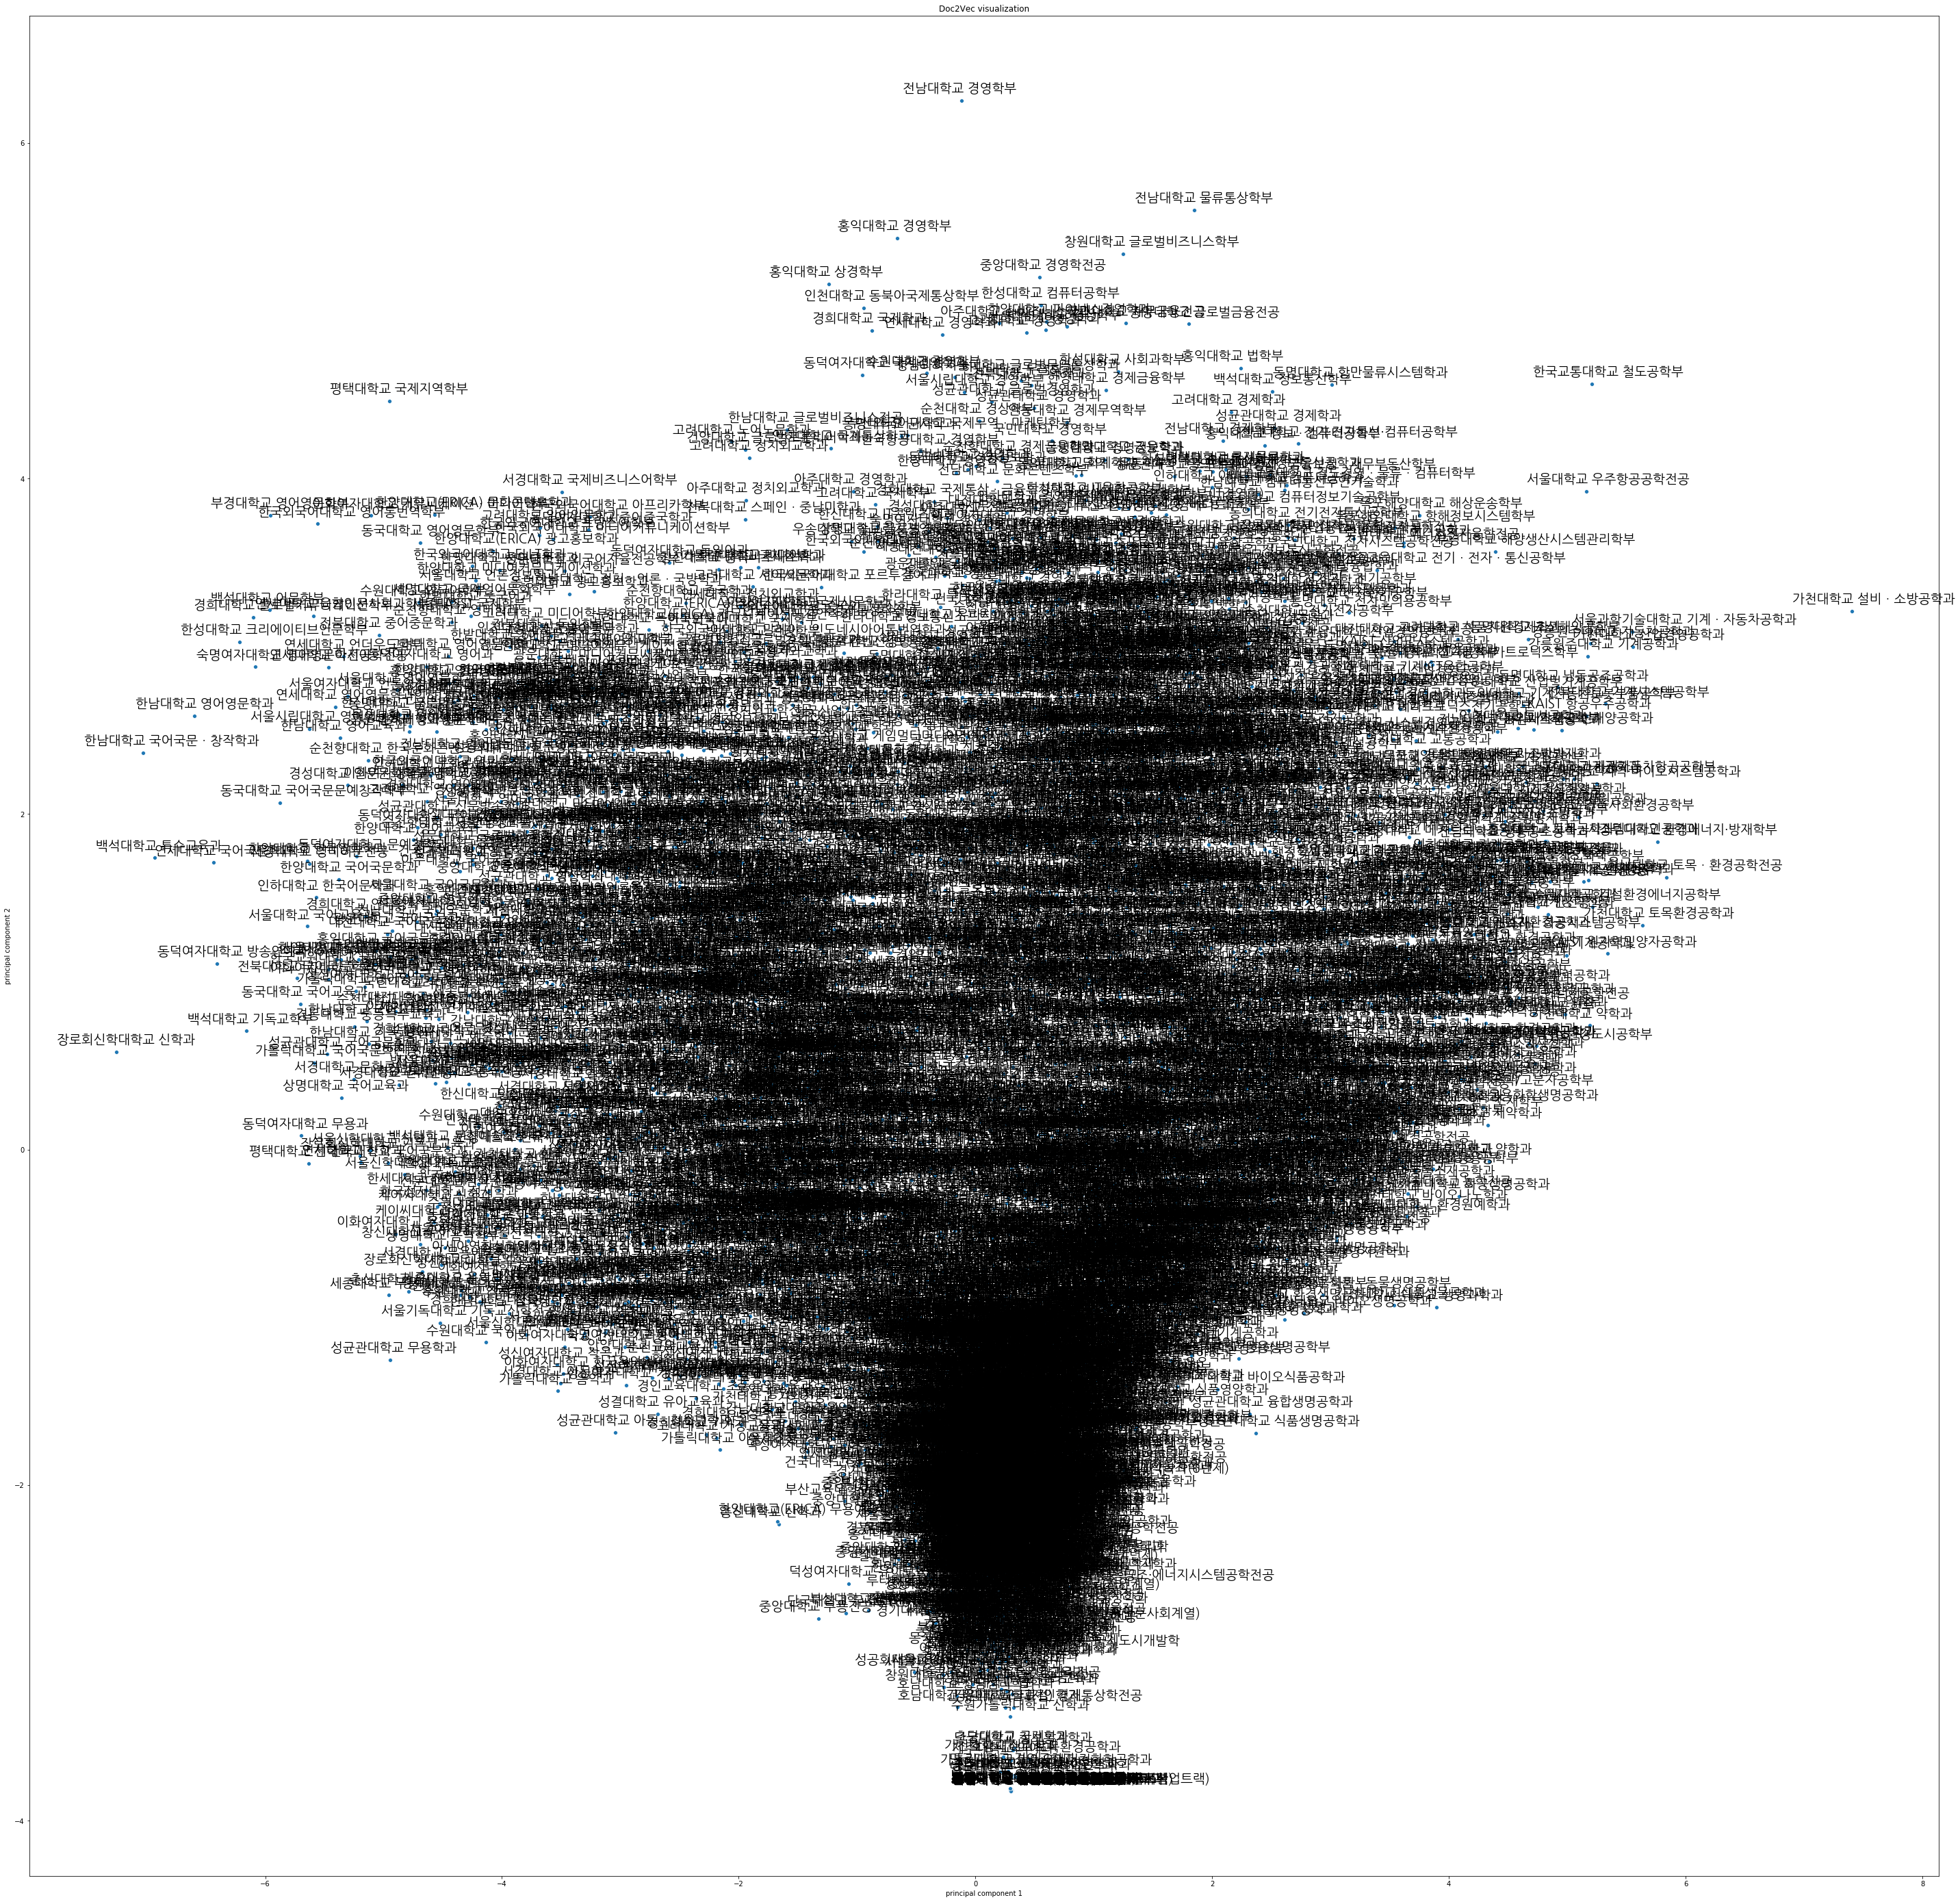

In [25]:
index_arr=[]
for i in range(len(df)):
    index_arr.append(df.index[i])

plt.figure(figsize=(50, 50))
ax=sns.scatterplot(x='principal component 1',y='principal component 2',data=df ) 
plt.title('Doc2Vec visualization')
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['font.size'] = 19
for i in range(len(df)):
    ax.text(float(df['principal component 1'][i]) - 0.5, float(df['principal component 2'][i]) + 0.05, df.index[i])